# Cluster resonance radicals

In [35]:
import string
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from tqdm import tqdm
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from rdmc.mol import RDKitMol

def make_rdkit_mol(smi):
    return RDKitMol.FromSmiles(smi)._mol

In [2]:
hbi_unc_df = pd.read_csv("../data/hbi_unc.csv")

In [3]:
cluster_df = hbi_unc_df[["resonance_radical_smiles"]]

In [4]:
def get_fingerprint(smi, method="morgan", count_based=False, **kwargs):
    mol = make_rdkit_mol(smi)
    if method == "rdkit":
        fpgen = rdFingerprintGenerator.GetRDKitFPGenerator(**kwargs)
    elif method == "morgan":
        fpgen = rdFingerprintGenerator.GetMorganGenerator(**kwargs)
    if count_based:
        fps = fpgen.GetCountFingerprintAsNumPy(mol)
    else:
        fps =  fpgen.GetFingerprintAsNumPy(mol)
    return fps

In [5]:
out = [get_fingerprint(smi, method="morgan", count_based=True) for smi in tqdm(hbi_unc_df["resonance_radical_smiles"])]

100%|██████████| 2809/2809 [00:02<00:00, 1200.14it/s]


In [6]:
X = np.vstack(out)
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [7]:
pca = PCA(random_state=0)
pca.fit(X)

PCA(random_state=0)

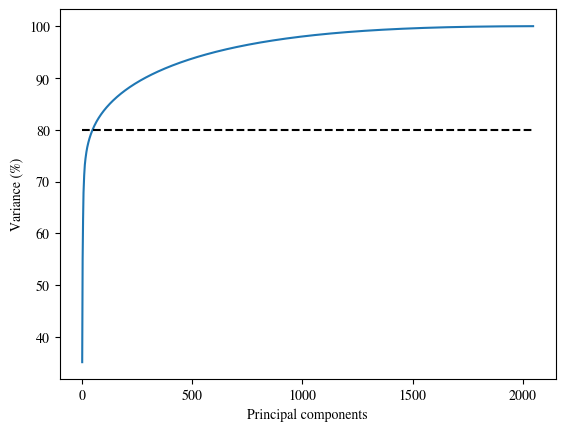

In [29]:
plt.figure()
var_percs = pca.explained_variance_ratio_ * 100
var_perc_cumsum = np.cumsum(var_percs)
xs = range(len(var_perc_cumsum))
plt.plot(xs, var_perc_cumsum)
plt.plot([xs[0], xs[-1]], [80, 80], "k--")
plt.xlabel("Principal components")
plt.ylabel("Variance (%)")
plt.savefig("../figures/variance_principal_components.pdf")

In [12]:
pca_80 = PCA(0.8, random_state=0)
X_pca = pca_80.fit_transform(X)
X_pca.shape

(2809, 48)

In [13]:
for ind in range(X_pca.shape[1]):
    cluster_df[f"PCA{ind}"] = X_pca[:, ind]

/home/gridsan/hwpang/mambaforge/envs/rmg_rdmc_env_20230623_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
max_n_clusters = 30
intertias = []
sh_scores = []
n_clusterss = range(1, max_n_clusters+1)
for n_clusters in tqdm(n_clusterss):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X_pca)
    intertias.append(kmeans.inertia_)


100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


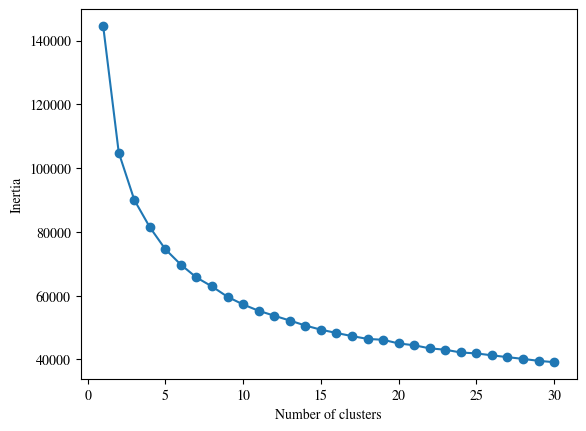

In [16]:
plt.figure()
plt.plot(n_clusterss, np.array(intertias), "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.savefig(f"../figures/kmeans_intertia_elbow.pdf")

Text(0, 0.5, 'Inertia change')

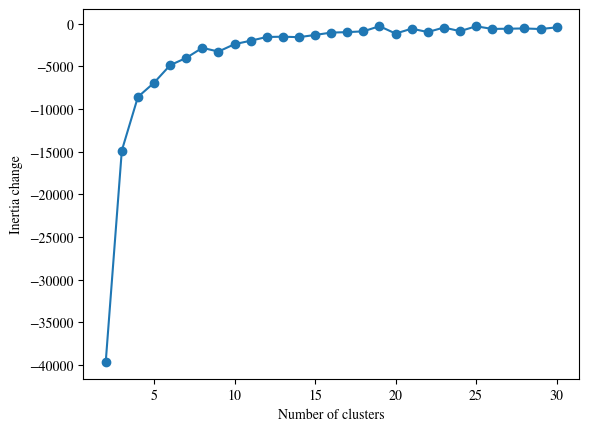

In [17]:
plt.figure()
plt.plot(n_clusterss[1:], np.diff(np.array(intertias)), "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia change")

In [18]:
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_pca)

KMeans(n_clusters=15, random_state=0)

In [24]:
cluster_df["cluster"] = kmeans.labels_
cluster_df

,resonance_radical_smiles,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,...,PCA39,PCA40,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,cluster
0,[O]C(=O)OC(O)(O)O,-6.079879,-1.622304,0.067782,-1.229347,0.271359,-1.519785,3.088279,0.931092,-0.173112,...,0.001748,-0.506148,-0.804516,-0.671943,-0.320503,-0.679838,0.118380,0.145438,-0.103366,3
1,[O]C(O)(O)OC(=O)O,-6.078900,-1.618632,0.064764,-1.223703,0.227364,-1.505660,3.171464,0.979332,-0.205473,...,-0.450763,-0.067586,-0.068352,-0.019818,0.142946,-0.278485,0.060743,0.287587,-0.101474,3
2,O=C(O)O[C](O)O,-6.070807,-1.669983,0.210494,-1.111290,0.257273,-1.891706,3.793958,1.891071,-0.174762,...,-0.560922,0.406048,0.326461,0.054025,-0.171151,0.355619,0.282723,0.159173,0.079878,3
3,CC(=O)OC(OO)C(=O)C(O)O[O],-0.914794,-2.619156,-0.112650,-1.769648,0.419368,-1.859175,4.413315,-2.435166,1.012287,...,0.168290,0.002688,-0.098459,-0.123082,0.432344,0.427751,0.244519,0.132819,-0.546545,2
4,O=[C]OC(O)(O)O,-6.036674,-1.328851,0.156109,-0.338871,0.086296,-1.533765,1.902881,1.225834,0.469501,...,-0.081655,-0.321211,-0.586774,-0.434472,0.026327,-0.713025,-0.281527,0.100749,0.018746,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,[C]1=CC=C1,-5.751150,1.455596,-1.611709,-0.443388,3.293826,-0.747569,-1.502389,0.506445,-0.137217,...,0.014668,0.026136,-0.128501,0.090305,-0.046023,-0.066374,0.049489,0.008142,0.048411,10
2805,C=C=C1C=[C]C1,-4.101180,1.891527,-0.956291,1.183054,-0.583466,-0.697610,-1.259569,0.089722,-0.049366,...,0.030221,0.061296,-0.217502,0.018507,0.027889,0.117062,-0.014419,-0.040369,-0.005597,10
2806,[CH2]C1=CC#CC1,-4.082018,1.943650,-0.973192,1.143766,-0.596421,-0.715223,-1.158040,0.086964,-0.061173,...,-0.089928,-0.013178,-0.199250,-0.341297,0.104356,-0.002598,-0.056287,0.019013,0.110630,10
2807,C=C1[CH]C#CC1,-4.090874,1.921561,-0.997500,1.060851,-0.662177,-0.748084,-1.174265,-0.129532,-0.057141,...,0.218655,-0.168782,-0.268803,0.211234,-0.263228,0.021495,-0.105034,0.033118,-0.283508,10


In [29]:
cluster_df.to_csv("../data/resonance_radical_cluster.csv", index=False)

In [26]:
cluster_df = pd.read_csv("../data/resonance_radical_cluster.csv")

In [27]:
cluster_counts = cluster_df["cluster"].value_counts().to_dict()
cluster_counts

{2: 418,
 3: 362,
 10: 305,
 9: 278,
 8: 238,
 5: 212,
 0: 203,
 4: 172,
 12: 168,
 7: 114,
 1: 112,
 6: 95,
 11: 65,
 13: 39,
 14: 28}

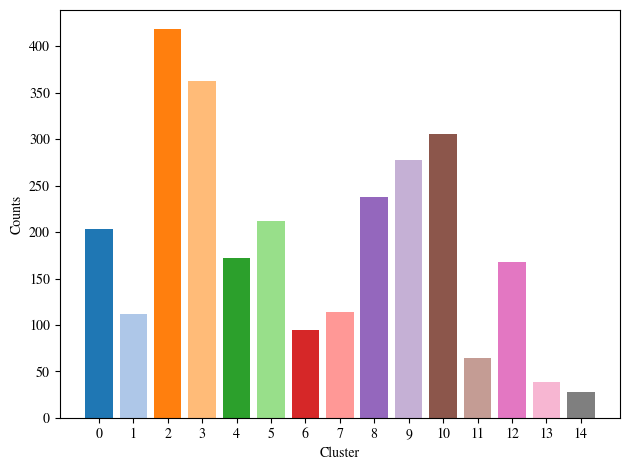

In [28]:
cmap = plt.get_cmap("tab20")

plt.figure()
xs = range(n_clusters)
for i, x in enumerate(xs):
    plt.bar([x], [cluster_counts[x]], color=cmap(i))
plt.xlabel("Cluster")
plt.ylabel("Counts")
plt.xticks(xs)
plt.tight_layout()
plt.savefig(f"../figures/kmeans_clustering_hist.pdf")

Text(0, 0.5, 'PCA 2')

<Figure size 640x480 with 0 Axes>

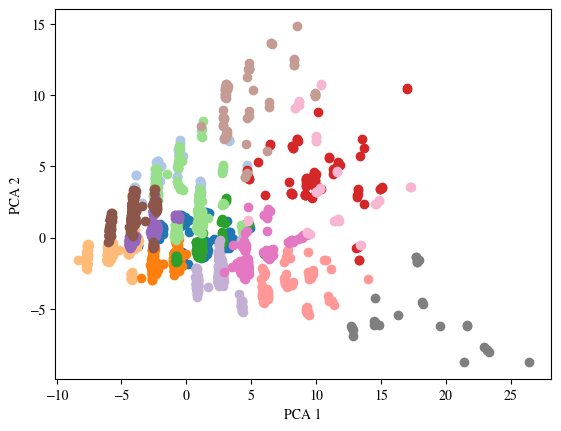

In [39]:
plt.set_cmap('tab20')
plt.figure()
for i in range(n_clusters):
    cluster_inds = cluster_df["cluster"] == i
    plt.scatter(X_pca[cluster_inds, 0], X_pca[cluster_inds, 1], label=i, color=cmap(i))

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
# plt.savefig(f"Figures/kmeans_clustering_pc1_pc2.pdf")

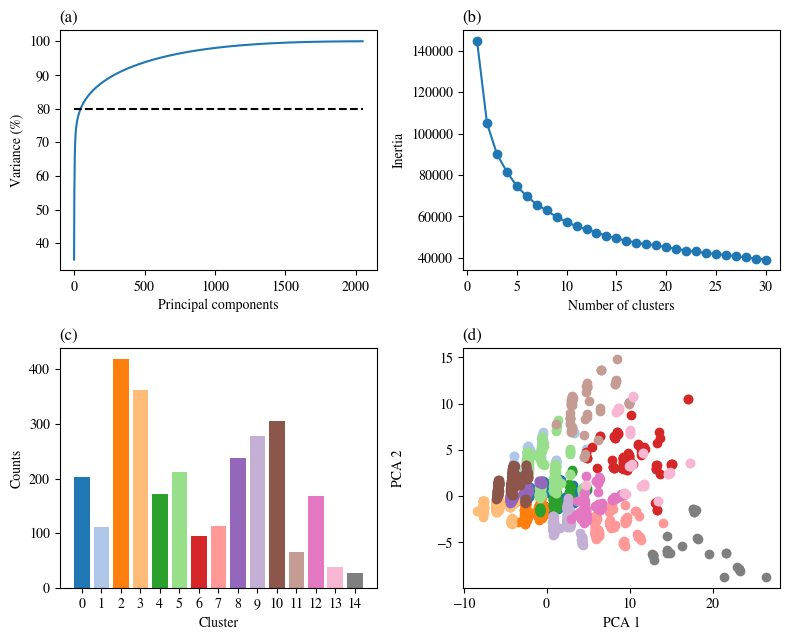

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6.5))

ax_i = 0
ax = axs.flat[ax_i]
var_percs = pca.explained_variance_ratio_ * 100
var_perc_cumsum = np.cumsum(var_percs)
xs = range(len(var_perc_cumsum))
ax.plot(xs, var_perc_cumsum)
ax.plot([xs[0], xs[-1]], [80, 80], "k--")
ax.set_xlabel("Principal components")
ax.set_ylabel("Variance (%)")
ax.set_title(f"({string.ascii_lowercase[ax_i]})", loc="left")

ax_i = 1
ax = axs.flat[ax_i]
ax.plot(n_clusterss, np.array(intertias), "-o")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Inertia")
ax.set_title(f"({string.ascii_lowercase[ax_i]})", loc="left")

ax_i = 2
ax = axs.flat[ax_i]
cmap = plt.get_cmap("tab20")
xs = range(n_clusters)
for i, x in enumerate(xs):
    ax.bar([x], [cluster_counts[x]], color=cmap(i))
ax.set_xlabel("Cluster")
ax.set_ylabel("Counts")
ax.set_xticks(xs)
ax.set_title(f"({string.ascii_lowercase[ax_i]})", loc="left")

ax_i = 3
ax = axs.flat[ax_i]
for i in range(n_clusters):
    cluster_inds = cluster_df["cluster"] == i
    ax.scatter(X_pca[cluster_inds, 0], X_pca[cluster_inds, 1], label=i, color=cmap(i))
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title(f"({string.ascii_lowercase[ax_i]})", loc="left")

fig.align_labels()
fig.tight_layout()
fig.savefig(f"../figures/pca_kmeans_clustering.pdf")